# Fitting Distributions

Author: Moritz Lotze <mlotze@km3net.de>

## Choose your dataset

Change this value to the data you want to test:

- noised_gauss
- bimodal_gauss

In [1]:
dataset = 'noised_gauss'

-----------------

In [2]:
# General imports

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm

from scipy.stats import norm

dsets = {}

## Generate Pseudo Data

### Bimodal Gaussian + Noise

In [3]:
N = 100

bmg = np.concatenate((np.random.normal(15, 1, 0.3 * N),
                    np.random.normal(20, 1, 0.7 * N)))
noise_bmg = 0.5
bimodal_gauss = np.random.normal(bmg, noise_bmg)[:, np.newaxis]
dsets['bimodal_gauss'] = bimodal_gauss

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/usr/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Single Gaussian + Noise

In [4]:
mu_t = 21.01
sig_t = 3.01
gaussian = np.random.normal(mu_t, sig_t, N)
noise = 0.4
noised_gauss = np.random.normal(gaussian, noise)[:, np.newaxis]
dsets['noised_gauss'] = noised_gauss

In [5]:
# make X axis for plots
x = np.linspace(5, 35, N+1)

In [6]:
data = dsets[dataset]

## Histograms

### Fixed Number of Bins
15 bins, spaced from `data.min()` to `data.max()`.

(array([ 0.01997159,  0.02995738,  0.07988634,  0.09985793,  0.09985793,
         0.11982951,  0.11982951,  0.10984372,  0.09985793,  0.10984372,
         0.03994317,  0.03994317,  0.00998579,  0.00998579,  0.00998579]),
 array([ 14.10644543,  15.1078682 ,  16.10929097,  17.11071374,
         18.1121365 ,  19.11355927,  20.11498204,  21.11640481,
         22.11782758,  23.11925035,  24.12067312,  25.12209588,
         26.12351865,  27.12494142,  28.12636419,  29.12778696]),
 <a list of 15 Patch objects>)

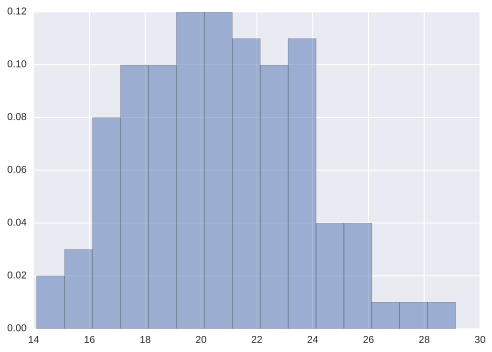

In [7]:
plt.hist(data, bins=15, alpha=.5, normed=True)

###  Auto Binning (recommended)
Use builtin (numpy's) heuristics to figure out best binning.

(array([ 0.0239659 ,  0.06590623,  0.10784656,  0.11982951,  0.11982951,
         0.09586361,  0.0479318 ,  0.01198295,  0.00599148]),
 array([ 14.10644543,  15.77548338,  17.44452133,  19.11355927,
         20.78259722,  22.45163517,  24.12067312,  25.78971106,
         27.45874901,  29.12778696]),
 <a list of 9 Patch objects>)

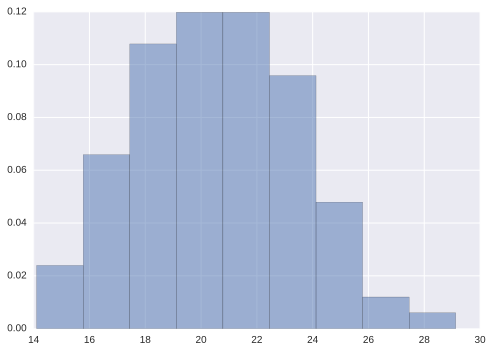

In [8]:
plt.hist(data, bins='auto', alpha=.5, normed=True)

### Knuth’s rule 
A fixed-width, Bayesian approach to determining the optimal bin width of a histogram.

(array([ 0.0239659 ,  0.06590623,  0.10784656,  0.11982951,  0.11982951,
         0.09586361,  0.0479318 ,  0.01198295,  0.00599148]),
 array([ 14.10644543,  15.77548338,  17.44452133,  19.11355927,
         20.78259722,  22.45163517,  24.12067312,  25.78971106,
         27.45874901,  29.12778696]),
 <a list of 9 Patch objects>)

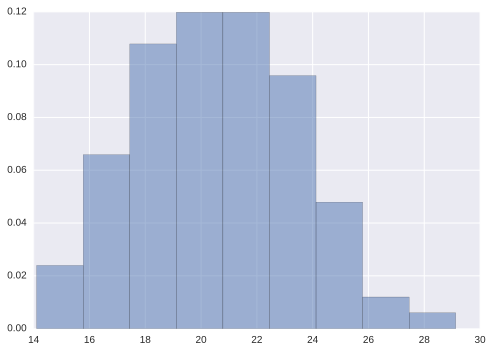

In [9]:
from astropy.stats import knuth_bin_width

width, knuth_binlims = knuth_bin_width(data=data[:, 0], return_bins=True)

plt.hist(data, bins=knuth_binlims, alpha=.5, normed=True)

## Fit a distribution (parametric)

If we have a hypothesis what the distribution looks like (e.g. gaussian), and want to fit its parameters.

### Fit Distribution via Maximum Likelihood (recommended)

The nice thing is, you can define your own PDFs in scipy and fit it.

In [10]:
from scipy.stats import norm
mu, sig = norm.fit(data)

True: Mean 21.01, stdev 3.01
Fit:  Mean 20.59, stdev 3.006


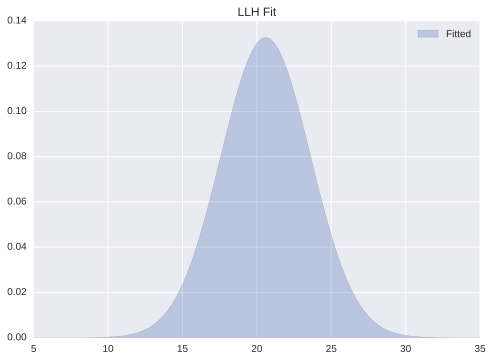

In [11]:
plt.fill(x, norm(mu, sig).pdf(x), alpha=.3, label='Fitted')
plt.legend()
print('True: Mean {:.4}, stdev {:.4}'.format(mu_t, sig_t))
print('Fit:  Mean {:.4}, stdev {:.4}'.format(mu, sig))
plt.title('LLH Fit')

### Fit Gaussian Mixture Model (GMM)

Assuming the data is the sum of one or more gaussians. Easily handles multidimensinal case as well.

In [12]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=1)
gmm.fit(data)
mu = gmm.means_[0, 0]
sig = np.sqrt(gmm.covariances_[0, 0, 0])

True: Mean 21.01, stdev 3.01
Fit:  Mean 20.59, stdev 3.006


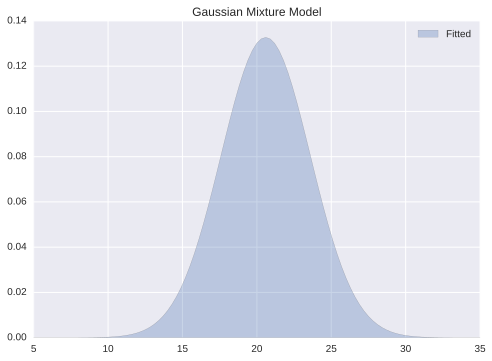

In [13]:
plt.fill(x, norm(mu, sig).pdf(x), alpha=.3, label='Fitted')
plt.legend()
print('True: Mean {:.4}, stdev {:.4}'.format(mu_t, sig_t))
print('Fit:  Mean {:.4}, stdev {:.4}'.format(mu, sig))
plt.title('Gaussian Mixture Model')

## Fit Distribution (non-parametric)

If we have no strong assumptions about the underlying pdf.
    

### Kernel Density

"Smooth out" each event with a kernel (e.g. gaussian) of a certain bandwidth, then add together all these mini-functions.

#### Implementation: Scikit-Learn

In [14]:
# sklearn kernel density
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KernelDensity

# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.logspace(-2, 2, 50)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data)

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

# use the best estimator to compute the kernel density estimate
kde = grid.best_estimator_

/usr/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


best bandwidth: 1.5998587196060574


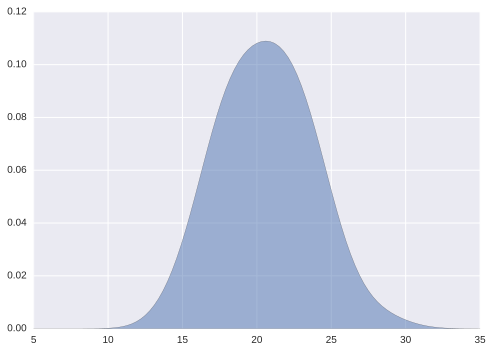

In [15]:
kde_dist = np.exp(
    kde.score_samples(x[:, np.newaxis])
)
plt.fill(x, kde_dist, alpha=.5, label='KDE')

#### Implementation: Statsmodels

In [16]:
dens = sm.nonparametric.KDEUnivariate(data)
dens.fit()

/usr/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


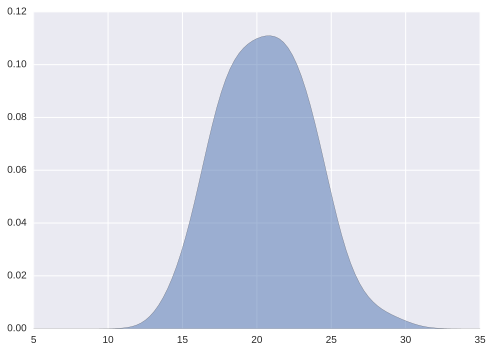

In [17]:
kde = dens.evaluate(x)
plt.fill(x, kde, alpha=.5, label='KDE')

## References

### Density estimation:

- B.W. Silverman, “Density Estimation for Statistics and Data Analysis”
- Hastie, Tibshirani and Friedman, “The Elements of Statistical Learning: Data Mining, Inference, and Prediction”, Springer, 2009.
- Liu, R., Yang, L. “Kernel estimation of multivariate cumulative distribution function.” Journal of Nonparametric Statistics (2008)